In [2]:
from collections import namedtuple
from igraph import Graph, plot, layout, Plot
%config InlineBackend.figure_format = 'png'

# Counting BST

In this notebook we will augment BST datastructure to allow use to answer questions like 

What is the $k$-th smallest element in the tree in time $O(lg\ n)$. The name of the function will be `kth_element`

First let's recap BST code:

In [32]:
class Node(object):
    def __init__(self, key):
        # node key - this is the value we compare to determine where 
        # the node should be inserted.
        self.key     = key
        # left child (can be none if no child)
        self.left    = None
        # right child (can be none if no child)
        self.right   = None
        
def BST_insert(where, key):
    """Inserts a node in a binary tree"""
    if where is None:
        # if we found a branch pointing to none, it means we
        # can insert the node here
        return Node(key)
    elif key <= where.key:
        # try inserting the node somewhere in the left subtree
        where.left = BST_insert(where.left, key)
    elif key > where.key:
        # try inserting the node in the right subtree
        where.right = BST_insert(where.right, key)
    return where

def BST_draw(node, g, display_count=False):
    """This method allows us to draw a binary tree.
    
    Don't worry about the implementation."""
    if node is None:
        return
    
    if node.left is not None:
        BST_draw(node.left,  g, display_count)
        left_id = str(id(node.left))
        left_color = "black"
    else:
        g.add_vertex(shape=0,)
        left_id = len(g.vs) - 1
        left_color = "#00000000"
    
    if node.right is not None:
        BST_draw(node.right, g, display_count)
        right_id = str(id(node.right))
        right_color = "black"
    else:
        g.add_vertex(shape=0,)
        right_id = len(g.vs) - 1
        right_color = "#00000000"

    label = str(node.key)
    if display_count:
        label = label + ' (count: %d)' % (node.count,)
        
    g.add_vertex(name=str(id(node)), label=label, 
                 shape="rectangle", color="lightblue")
    if node.left is not None or node.right is not None:
        g.add_edge(str(id(node)), left_id, color=left_color)
        g.add_edge(str(id(node)), right_id, color=right_color)
            
def BST_root_draw(root, display_count=False, width=500, height=300, margin=50):
        figure = Plot(bbox=(width, height))
        
        g = Graph()
        if root is not None:
            BST_draw(root, g, display_count)
            root_id = [i for i, node in enumerate(g.vs) if g.vs[i]['name'] == str(id(root))]
            assert len(root_id) == 1
            figure.add(g, layout = Graph.layout_reingold_tilford(g, mode="in", root=root_id), 
                        bbox=(margin, margin, width-margin, height - margin), vertex_size=30)
            return figure
            
class BST(object):
    def __init__(self):
        self.root = None
    
    def empty(self):
        return self.root is None
    
    def insert(self, key):        
        self.root = BST_insert(self.root, key)
    
    def draw(self, display_count=False):
        return BST_root_draw(self.root, display_count)

## First step towards the `kth_element`: counting

One thing that we will need for an efficient implementation of `kth_element` is the ability to quickly answer the questions of form - how many nodes are the in subtree rooted in $X$. We can compute it online in time proportional to the size of the subtree, but since we will need to compute it frequently, we will try to keep the information availble at all times.

More formally let $count_X$ be a size of a subtree rooted in $X$. It is defined by the following recursive relation:

$$
count_X =
\begin{cases}
0                &\text{ if } X = NIL \\
count_{X_L} + count_{X_R} + 1 &\text{otherwise}
\end{cases}
$$

Let's augment the node to be able to keep track of count!

In [33]:
class Node(object):
    def __init__(self, key):
        self.key     = key
        self.left    = None
        self.right   = None
        
        self.count   = 1 # <---- here we store the count
    
    # If any of the subtrees change we need to recompute count using the recursive formula
    def recompute_count(self):
        left_count  = self.left.count  if self.left  is not None else 0
        right_count = self.right.count if self.right is not None else 0
        self.count = left_count + right_count + 1

### Insertion keeping track of count

Let's now modify the insertion code to keep track of count. This should be quite easy, all we need to do is recompute count if any of the children of particular node changed.

In [34]:
def BST_insert(where, key):
    """Inserts a node in a binary tree"""
    if where is None:
        # if we found a branch pointing to none, it means we
        # can insert the node here
        return Node(key)
    elif key <= where.key:
        # try inserting the node somewhere in the left subtree
        where.left = BST_insert(where.left, key)
    elif key > where.key:
        # try inserting the node in the right subtree
        where.right = BST_insert(where.right, key)
        
    where.recompute_count() # <------- THIS IS THE ONLY LINE THAT CHANGED
        
    return where

### Let's verify that the code works

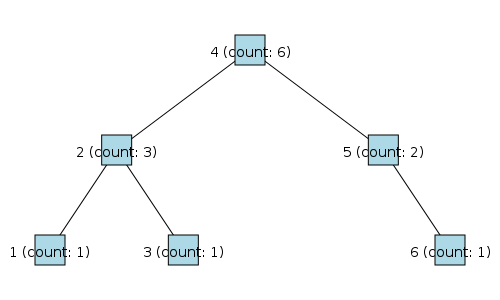

In [39]:
tree = BST()
for el in [4,2,1,3,5,6]:
    tree.insert(el)
tree.draw(display_count=True)

## `kth_element` implementation

**Observation** Let $X$ be a node and $X_{key}$ its key. If $X_{key}$ is $k$-th node in the sorted order then $ k > count_{X_L}$. 

**Explanation** All the nodes in the left subtree are smaller than $X_{key}$ (for simplicity assume all are distinct). 


This observation is fundamental for the To implement `kth_element` function. Let's consider three cases. Let's assume `kth_element(X, k)` returns $k$ element in the tree rooted in $X$.

#### Case 1: Result is in the left subtree

This case occurs if $count_{X_L} \geq k$. In that case we return kth_element($X_L$, k).

#### Case 2: Result is in the root

This case occurs if $count_{X_L} + 1 = k$. In that case we return $X_{key}$

#### Case 3: Result is in the right subtree

This case occurs if $count_{X_L} + 1 < k$. In that case we return kth_element($X_R$, $k - (count_{X_L} + 1)$). 

In [54]:
def BST_kth_element(node, k):
    if node is None or k < 1:
        return None
    left_count = node.left.count if node.left is not None else 0
    if left_count >= k:
        return BST_kth_element(node.left, k)
    elif left_count + 1 == k:
        return node
    elif left_count + 1 < k:
        return BST_kth_element(node.right, k - (1 + left_count))

## Verify on example

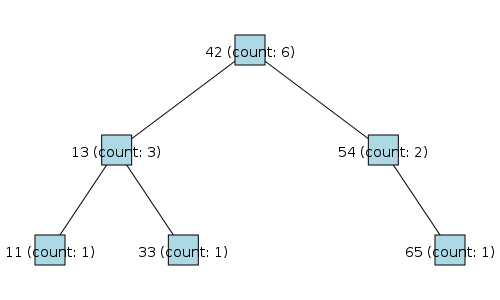

In [55]:
tree = BST()
for el in [42,13,11,33,54,65]:
    tree.insert(el)
tree.draw(display_count=True)

In [56]:
BST_kth_element(tree.root, 0) is None

True

In [57]:
for k in range(1, 7):
    print('%d-th element is %d' % (k, BST_kth_element(tree.root, k).key))

1-th element is 11
2-th element is 13
3-th element is 33
4-th element is 42
5-th element is 54
6-th element is 65


In [58]:
BST_kth_element(tree.root, 7) is None

True

In [59]:
print('Median is %d' % (BST_kth_element(tree.root, tree.root.count / 2).key))

Median is 33


## Exercise

Augment BST code for deletion to keep track of the count. Deletion code is available in notebook for lecture5.